# Import Libraries

In [136]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# Load names.txt file

In [137]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

# Mapping charts into unique ids

In [138]:
chars = sorted(set(''.join(words)))
ch2i = {ch: i + 1 for i, ch in enumerate(chars)}
ch2i['.'] = 0
i2ch = {i: ch for ch, i in ch2i.items()}
i2ch

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Splitting data into train, validation and test set

In [139]:
def build_dataset(words):
    block_size = 3
    X, y = [], []

    for w in words:
        context = [0] * (block_size - 1) + [ch2i[w[0]]]
        for ch in w[1:] + '.':
            ch_id = ch2i[ch]
            X.append(context)
            y.append(ch_id)
            context = context[1:] + [ch_id]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

random.seed(42)
random.shuffle(words)
split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:split1])
X_valid, y_valid = build_dataset(words[split1:split2])
X_test, y_test = build_dataset(words[split2:])

torch.Size([156999, 3]) torch.Size([156999])
torch.Size([19452, 3]) torch.Size([19452])
torch.Size([19662, 3]) torch.Size([19662])


# Fixing the initial loss

In [140]:
block_size = 3
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


## Initial loss without fixing

In [141]:
batch_size = 32

batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

emb = C[X_batch]
embcat = emb.view(emb.shape[0], -1)
h_preact = embcat @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_batch)

print(loss)

tensor(25.9091, grad_fn=<NllLossBackward0>)


At the first step of training, the model parameters are initiliazed randomly. As the result, the network produces completely random predictions. Some logits are very confident, while others are not confident at all, which leads to the fact that the model is very confidently wrong.
  
Below are the logits produced by the model at the first training step:

In [142]:
logits[0]

tensor([ 11.8567,   2.3145,  -4.6198, -10.7482,   5.4782, -15.8860,  -5.6611,
         -2.6880, -28.4938,   3.3646, -11.6713,  22.4667,  -3.1490,  -8.6217,
         24.1164,   9.8226,   4.1427,  -5.3497,  10.0275,   0.8393,  17.0741,
         17.9978,  -9.5378, -20.8774,  12.3255,  21.4833,  12.6346],
       grad_fn=<SelectBackward0>)

In [143]:
F.softmax(logits[0], dim=0)

tensor([3.7402e-06, 2.6839e-10, 2.6136e-13, 5.6980e-16, 6.3496e-09, 3.3448e-18,
        9.2261e-14, 1.8039e-12, 1.1192e-23, 7.6706e-10, 2.2637e-16, 1.5162e-01,
        1.1376e-12, 4.7779e-15, 7.8922e-01, 4.8922e-07, 1.6701e-09, 1.2597e-13,
        6.0046e-07, 6.1392e-11, 6.8988e-04, 1.7375e-03, 1.9115e-15, 2.2732e-20,
        5.9771e-06, 5.6709e-02, 8.1423e-06], grad_fn=<SoftmaxBackward0>)

These values show that the logits have a very wide range. Some logits are extremely high, while others are extremely low. These logits passed through softmax functions lead to very confident predictions for some classes and near-zero probabilities for others, even though the model has not learned anything.  
  
In reality, at the beginning of training, the model should produce a probability distribution close to uniform, representing maximum uncertainty. This allows us to estimate the expected initial loss for our case.

In our case, the model is trying to predict the next character from a vocabulary of 27 characters. Therefore, under a uniform probability distribution, the expected loss is:

$$
-\log\left(\frac{1}{27}\right) = 3.2958
$$

## Initial loss with setting the weights and biases of last layer as th near-zero numbers

One way to achieve this is to initialize the weights and biases of the final layer to values close to zero. In this case, the logits will also be close to zero, and the softmax function will produce a probability distribution that is approximately uniform.

In [144]:
block_size = 3
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [145]:
batch_size = 32

batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

emb = C[X_batch]
embcat = emb.view(emb.shape[0], -1)
h_preact = embcat @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_batch)

print(loss)

tensor(3.3096, grad_fn=<NllLossBackward0>)


In [146]:
logits[0]

tensor([-0.0382,  0.0204,  0.3070, -0.1587,  0.1099,  0.4179, -0.0389,  0.0592,
         0.2282,  0.0047, -0.3041, -0.0928,  0.0466, -0.1291, -0.0557, -0.0822,
         0.0450,  0.3250,  0.0365,  0.1335,  0.1455,  0.0032,  0.0840,  0.1996,
         0.1912, -0.1283,  0.0882], grad_fn=<SelectBackward0>)

In [147]:
F.softmax(logits[0], dim=0)

tensor([0.0334, 0.0354, 0.0472, 0.0296, 0.0387, 0.0527, 0.0334, 0.0368, 0.0436,
        0.0349, 0.0256, 0.0316, 0.0364, 0.0305, 0.0328, 0.0320, 0.0363, 0.0480,
        0.0360, 0.0397, 0.0401, 0.0348, 0.0377, 0.0424, 0.0420, 0.0305, 0.0379],
       grad_fn=<SoftmaxBackward0>)

As we can see, the loss is indeed close to the expected value, and the range of predicted probabilities is much narrower.

## Fixing the saturated tanh

The next problem with our initialization is related to the values after the activation function (tanh).

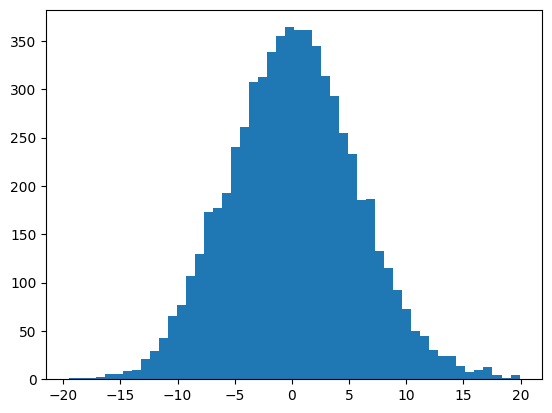

In [148]:
plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.show()

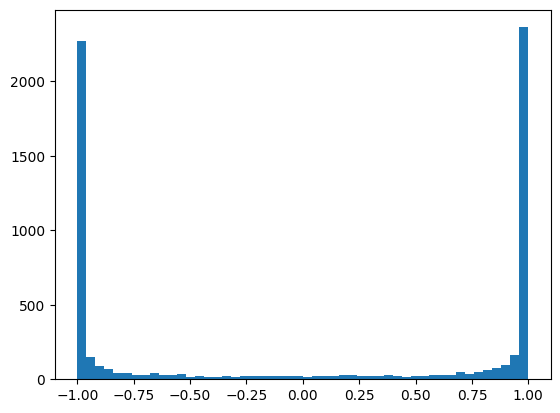

In [149]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

Due to the large magnitude of the pre-activation values, most of the outputs of the tanh function are pushed into its saturated regions. As a result, the majority of activation values are very close to -1 or 1.  
  
In the saturated regions of the tanh function, the derivative approaches zero. During backpropagation, this leads to vanishing gradients, preventing effective weight updates for many neurons.
  
The derivative approaches zero because the derivative of the `tanh` function is given by:

$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$

When the output of tanh(x) is close to -1 or 1, the term $(tanh^2(x))$ approaches 1, causing the derivative to approach zero.

To prevent this issue, we need to control the scale of the activations rather than set all weights close to zero. By carefully choosing the initialization scale for each layer, we can keep the pre-activation values within a reasonable range.

In the implementation below, different layers are initialized with different scales:

- `W1` is scaled by `0.2` to reduce the magnitude of inputs to the `tanh` activation
- `b1` is initialized to zero to avoid shifting activations into the saturated regions
- `W2` is scaled by `0.01` to keep the logits close to zero at initialization
- `b2` is initialized to zero to maintain balanced output logits


In [150]:
block_size = 3
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [151]:
batch_size = 32

batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

emb = C[X_batch]
embcat = emb.view(emb.shape[0], -1)
h_preact = embcat @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_batch)

print(loss)

tensor(3.2701, grad_fn=<NllLossBackward0>)


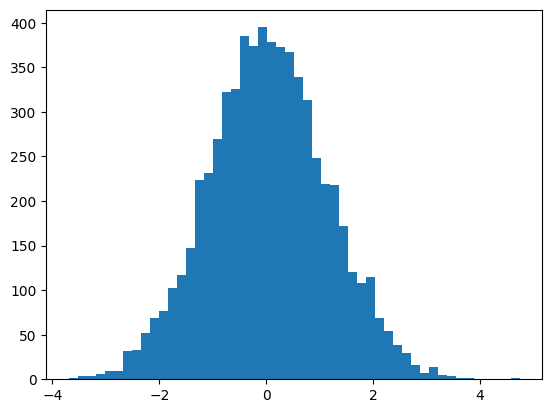

In [152]:
plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.show()

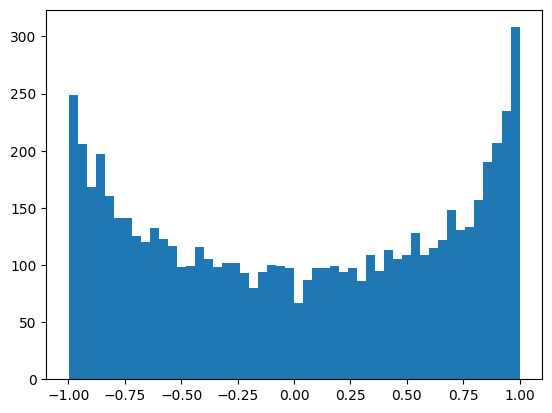

In [153]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

This approach works well for small and shallow networks, where we can manually control the scale of activations layer by layer. However, as the model becomes deeper and more complex, such manual tuning quickly becomes impractical.

For larger models with many layers, specialized weight initialization schemes are commonly used. One popular example is Kaiming initialization, which is designed to preserve the variance of activations across layers and prevent exploding or vanishing gradients, especially when using ReLU-based activation functions.


## Kaiming init

The main goal of Kaiming initialization is to preserve stable signal propagation through deep networks by maintaining consistent activation variance across layers.
  
Below we show the distributions of the input `x` and the output `y = x @ w` for a linear layer with randomly initialized weights. At this stage, no Kaiming initialization is applied — both `x` and `w` are sampled from a standard normal distribution.

tensor(-0.0008) tensor(0.9984)
tensor(-0.0004) tensor(3.2206)


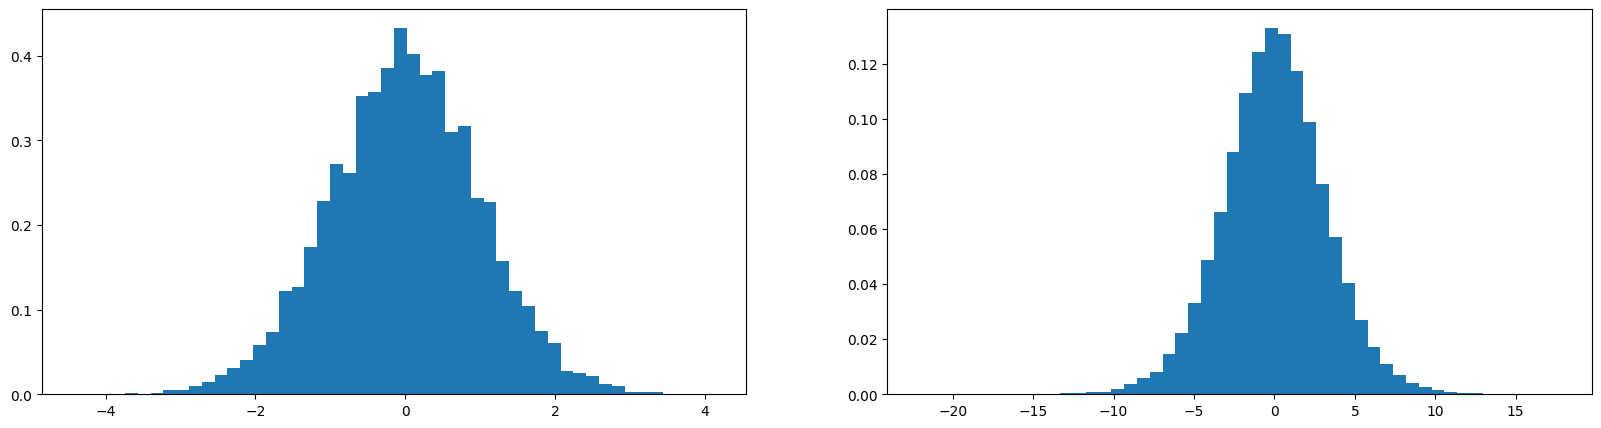

In [154]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

We can see that the input `x` indeed follows a normal distribution with mean equal to 0 and standard deviation equal to 1, as expected. However, the output distribution also has mean close to 0, but its standard deviation increases to 3.17.  
  
Kaiming initialization does not aim to preserve unit variance in linear layers, but to maintain stable variance after activation functions in deep networks.
  
Kaiming initialization defines the standard deviation of the weight distribution as:

$$
\text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_in}}}
$$

where `fan_in` is the number of input connections to a neuron.

The examples of common values of gain:
- ReLU:
  $
  \text{gain} = \sqrt{2}
  $

- Leaky ReLU (negative slope = \(a\)):
  $
  \text{gain} = \sqrt{\frac{2}{1 + a^2}}
  $

- Tanh:
  $
  \text{gain} = \frac{5}{3}
  $

- Sigmoid:
  $
  \text{gain} = 1
  $

In practice, with the development of increasingly advanced optimization methods, normalization techniques, and architectural improvements, strict adherence to specialized initialization schemes has become less critical.

In many production systems, a simple scaling based on the number of input connections is often sufficient, and weights are commonly initialized with a standard deviation proportional to $(1 / \sqrt{\text{fan\_in}})$.


In [155]:
block_size = 3
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [156]:
batch_size = 32

batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

emb = C[X_batch]
embcat = emb.view(emb.shape[0], -1)
h_preact = embcat @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_batch)

print(loss)

tensor(3.2670, grad_fn=<NllLossBackward0>)


# Batch Normalization

Batch Normalization is used to stabilize and accelerate training by controlling the distribution of activations throughout the network.

During training, the distributions of activations change as the model parameters are updated. This can cause activations to drift into undesirable regimes, such as saturated regions of nonlinearities, leading to vanishing or exploding gradients. Batch Normalization addresses this problem by normalizing activations to have zero mean and unit variance within each mini-batch.

By keeping activations centered and properly scaled, Batch Normalization ensures that nonlinearities such as `tanh` or `ReLU` operate in their effective regimes, allowing gradients to flow more reliably through the network.


Batch Normalization normalizes activations within a mini-batch using the following equations.

Given a batch of activations \(x_1, x_2, \dots, x_m\):

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$

The normalized activations are then computed as:

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

Finally, Batch Normalization applies a learnable scale and shift:

$$
y_i = \gamma \hat{x}_i + \beta
$$

where $(\gamma)$ and $(\beta)$ are trainable parameters and $(\epsilon)$ is a small constant added for numerical stability.


In [ ]:
block_size = 3
vocab_size = len(ch2i)
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# Bias for layers that are normalize using e.g. BatchNormalization is unnecessary
# b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# At the beginning we want Batch Normalization makes the distribution roughly Gaussian without scaling or shifting them.
# Therefore, gamma is initialized to 1 and beta to 0.
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1)
    # Linear Layer
    h_preact = embcat @ W1
    
    # BatchNorm Layer
    # --------------------------------------------------------------------------------
    bn_mean_i = h_preact.mean(dim=0, keepdim=True)
    bn_std_i = h_preact.std(dim=0, keepdim=True) + 1e-5
    h_preact = bn_gain * (h_preact - bn_mean_i) / bn_std_i + bn_bias
    
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    # --------------------------------------------------------------------------------

    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_batch)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3020


  10000/ 200000: 1.9755
  20000/ 200000: 1.8274
  30000/ 200000: 2.0460
  40000/ 200000: 1.7469
  50000/ 200000: 2.2717
  60000/ 200000: 1.9922
  70000/ 200000: 2.1376
  80000/ 200000: 1.7061
  90000/ 200000: 2.1245
 100000/ 200000: 1.8017
 110000/ 200000: 1.9332
 120000/ 200000: 2.0176
 130000/ 200000: 1.9052
 140000/ 200000: 2.0701
 150000/ 200000: 1.8362
 160000/ 200000: 1.8185
 170000/ 200000: 2.0683
 180000/ 200000: 1.4547
 190000/ 200000: 1.6316


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_valid, y_valid),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h_preact = embcat @ W1
  h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
  h = torch.tanh(h_preact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.912745714187622
val 1.9658626317977905


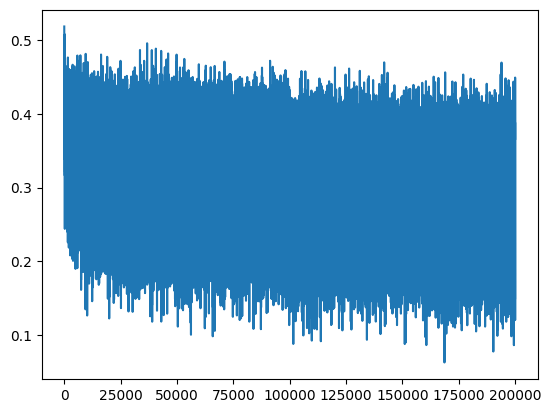

In [188]:
plt.plot(lossi)
plt.show()

# Model Inference

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    first_char = torch.randint(1, len(ch2i), (1,)).item()
    context = [0] * (block_size - 1) + [first_char]
    out.extend(context[1:])

    while True:
        emb = C[context]
        embcat = emb.view(1, -1)
        h_preact = embcat @ W1
        h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(i2ch[i] for i in out))

.ychamarxate.
.ulle.
.ghi.
.rori.
.oreaty.
.uhaan.
.sane.
.arron.
.safaperric.
.careei.
.zaramari.
.hamaiir.
.des.
.meggy.
.oham.
.berin.
.dessan.
.tarline.
.rivanni.
.norathonielryxi.


# Deeper Network

## Layers

In [264]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
    
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

## Plotting outs

In [290]:
def plot_outs(layers, ud):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 18))

    legends_ax_1 = []
    print('Activation Distribution')
    for i, layer in enumerate(layers[:-1]):        
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            axes[0].plot(hx[:-1].detach(), hy.detach())
            legends_ax_1.append(f'layer {i} ({layer.__class__.__name__})')
            axes[0].legend(legends_ax_1)
            axes[0].set_title('activation distribution')

    print('Gradient Distribution')
    legends_ax_2 = []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            print('layer %d (%10s): mean %+f, std %e, saturated: %f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            axes[1].plot(hx[:-1].detach(), hy.detach())
            legends_ax_2.append(f'layer {i} ({layer.__class__.__name__})')
            axes[1].legend(legends_ax_2)
            axes[1].set_title('gradient distribution')

    print('Weights Gradient Distribution')
    legends_ax_3 = []
    for i, p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            axes[2].plot(hx[:-1].detach(), hy.detach())
            legends_ax_3.append(f'{i} {tuple(p.shape)}')
            axes[2].legend(legends_ax_3)
            axes[2].set_title('weights gradient distribution')

    legends_ax_4 = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            axes[3].plot([ud[j][i] for j in range(len(ud))])
            legends_ax_4.append('param %d' % i)
            axes[3].plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot. Otherwise the model is not training as fast 
            axes[3].legend(legends_ax_4);
            axes[3].set_title('activation distribution')

    plt.show()


## Without Batch Normalization ang gain 3 (too high)

In [291]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident at the beginning
    layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [292]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.3046


Activation Distribution
layer 1 (      Tanh): mean -0.06, std 0.87, saturated: 49.38%
layer 3 (      Tanh): mean +0.01, std 0.85, saturated: 44.06%
layer 5 (      Tanh): mean -0.01, std 0.86, saturated: 47.34%
layer 7 (      Tanh): mean -0.01, std 0.86, saturated: 44.88%
layer 9 (      Tanh): mean -0.04, std 0.85, saturated: 45.34%
Gradient Distribution
layer 1 (      Tanh): mean -0.000224, std 8.018664e-03, saturated: 0.000000%
layer 3 (      Tanh): mean -0.000072, std 6.028455e-03, saturated: 0.000000%
layer 5 (      Tanh): mean +0.000021, std 4.586510e-03, saturated: 0.000000%
layer 7 (      Tanh): mean -0.000049, std 3.559191e-03, saturated: 0.000000%
layer 9 (      Tanh): mean -0.000009, std 2.608871e-03, saturated: 0.000000%
Weights Gradient Distribution
weight   (27, 10) | mean +0.000873 | std 3.373082e-02 | grad:data ratio 3.369424e-02
weight  (30, 100) | mean +0.000331 | std 1.973676e-02 | grad:data ratio 3.507520e-02
weight (100, 100) | mean +0.000246 | std 1.269020e-02 | gra

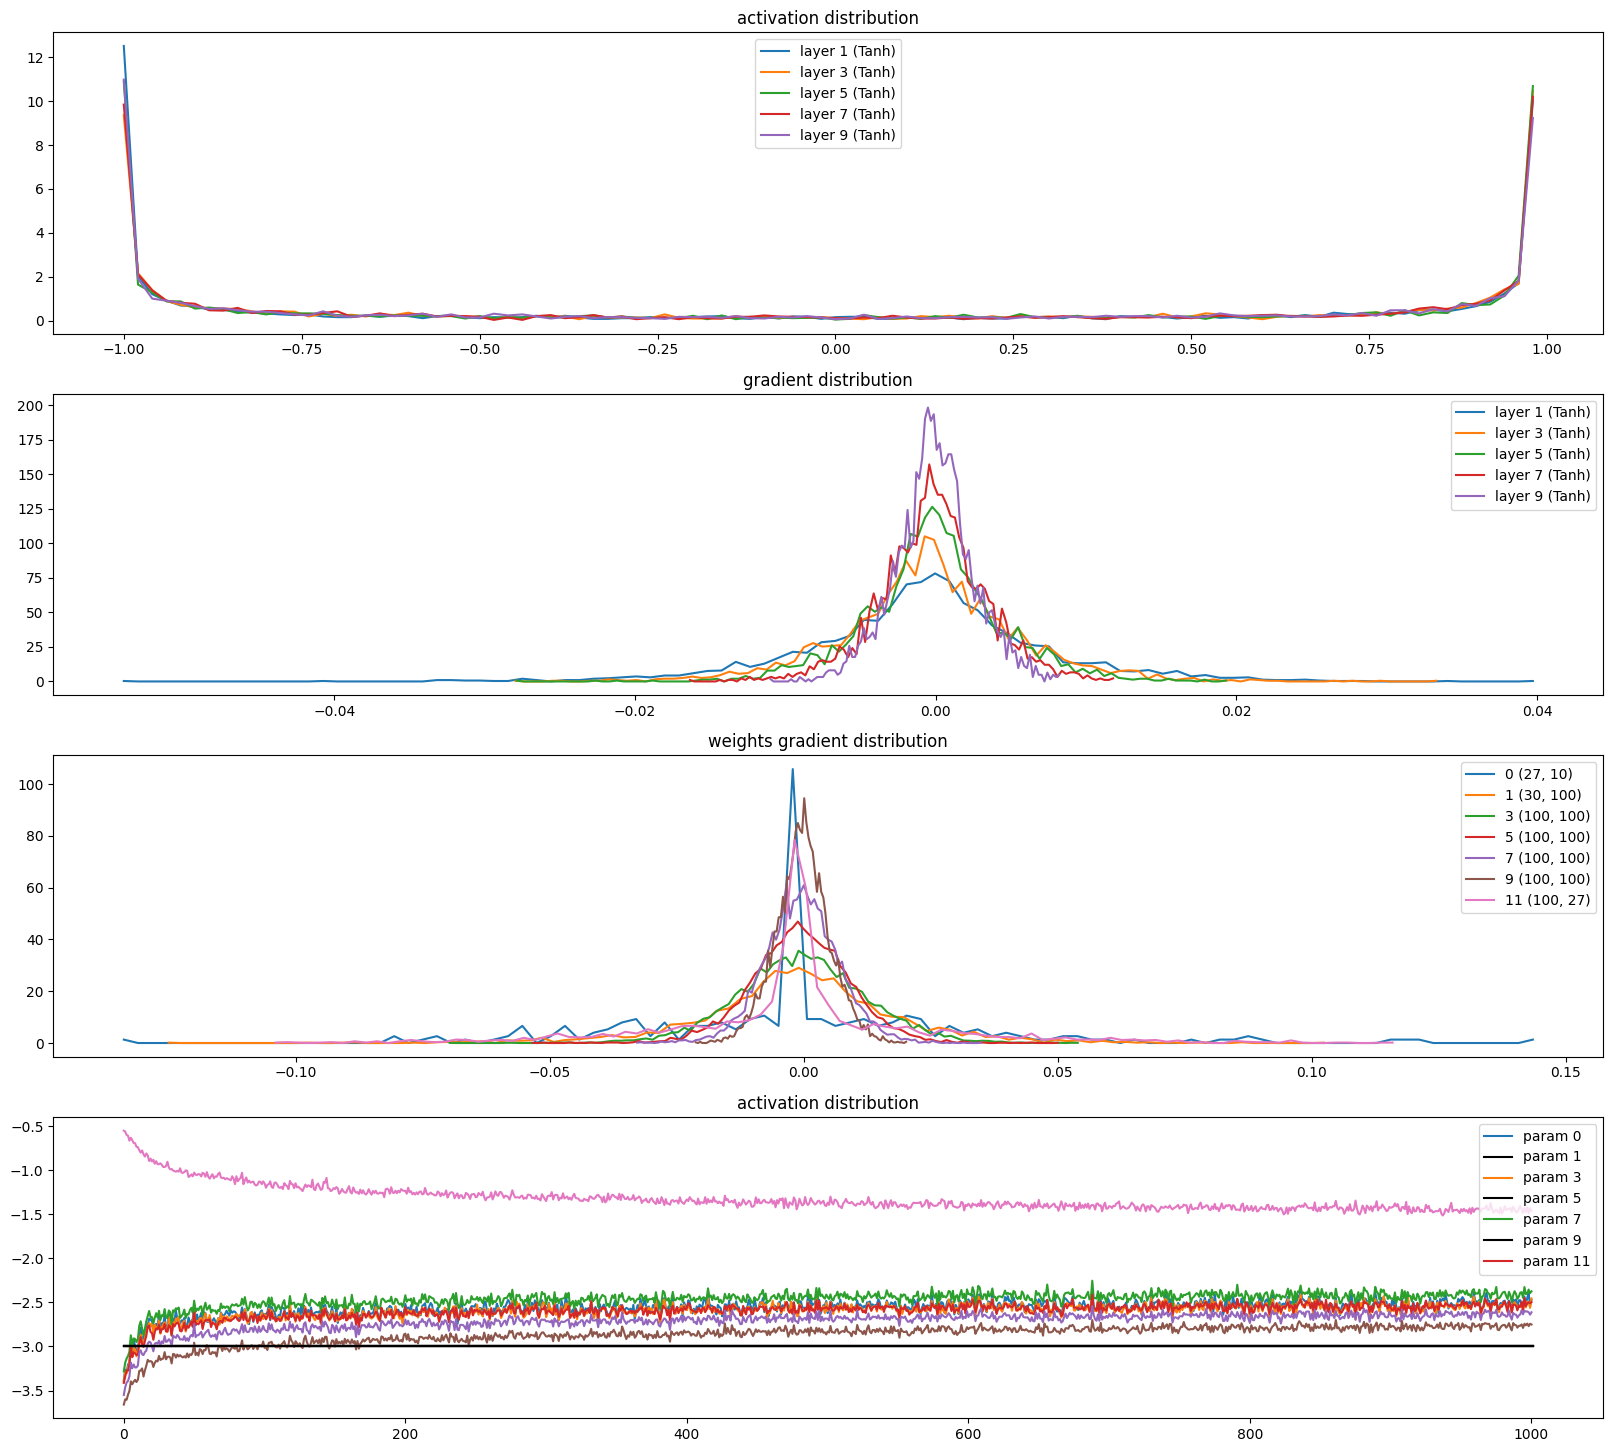

In [293]:
plot_outs(layers, ud)

## Without Batch Normalization ang gain 0.3 (too low)

In [309]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident at the beginning
    layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [310]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.2959


Activation Distribution
layer 1 (      Tanh): mean -0.02, std 0.30, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.13, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.09, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.10, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.20, saturated: 0.00%
Gradient Distribution
layer 1 (      Tanh): mean -0.000001, std 2.643862e-04, saturated: 0.000000%
layer 3 (      Tanh): mean +0.000000, std 3.472155e-04, saturated: 0.000000%
layer 5 (      Tanh): mean +0.000004, std 4.495930e-04, saturated: 0.000000%
layer 7 (      Tanh): mean +0.000002, std 5.631805e-04, saturated: 0.000000%
layer 9 (      Tanh): mean +0.000004, std 6.894451e-04, saturated: 0.000000%
Weights Gradient Distribution
weight   (27, 10) | mean +0.000009 | std 8.746143e-04 | grad:data ratio 8.733302e-04
weight  (30, 100) | mean -0.000008 | std 1.393558e-03 | grad:data ratio 2.430721e-02
weight (100, 100) | mean +0.000000 | std 5.907523e-04 | grad:dat

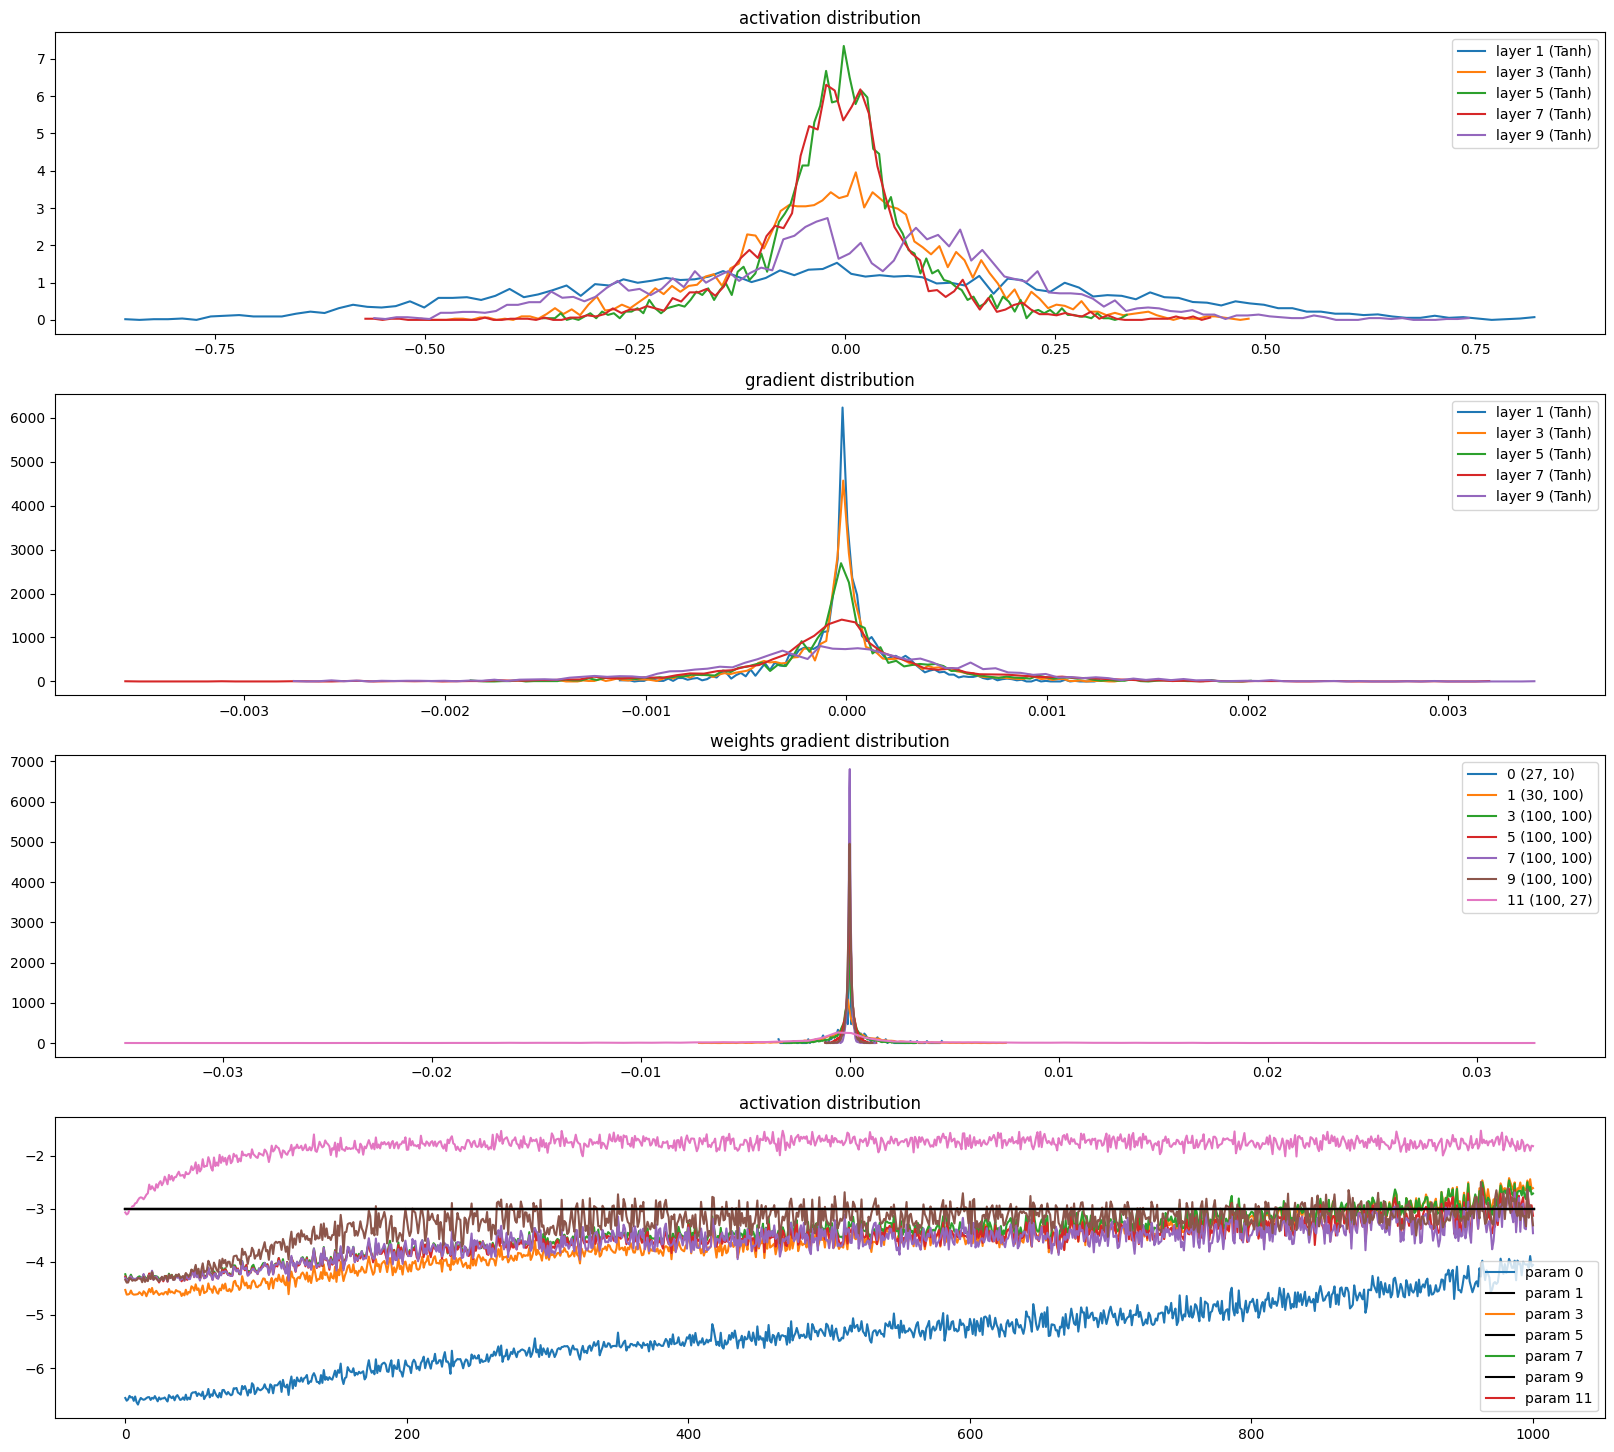

In [311]:
plot_outs(layers, ud)

## Without Batch Normalization ang gain 5/3

In [303]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident at the beginning
    layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [304]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.3049


Activation Distribution
layer 1 (      Tanh): mean -0.05, std 0.77, saturated: 23.22%
layer 3 (      Tanh): mean +0.03, std 0.72, saturated: 12.25%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 14.22%
layer 7 (      Tanh): mean -0.03, std 0.72, saturated: 11.88%
layer 9 (      Tanh): mean -0.04, std 0.71, saturated: 10.69%
Gradient Distribution
layer 1 (      Tanh): mean -0.000019, std 3.628042e-03, saturated: 0.000000%
layer 3 (      Tanh): mean +0.000090, std 3.360798e-03, saturated: 0.000000%
layer 5 (      Tanh): mean -0.000095, std 3.236295e-03, saturated: 0.000000%
layer 7 (      Tanh): mean -0.000042, std 3.040161e-03, saturated: 0.000000%
layer 9 (      Tanh): mean -0.000034, std 2.499854e-03, saturated: 0.000000%
Weights Gradient Distribution
weight   (27, 10) | mean +0.000220 | std 1.319367e-02 | grad:data ratio 1.318432e-02
weight  (30, 100) | mean -0.000086 | std 1.105376e-02 | grad:data ratio 3.530189e-02
weight (100, 100) | mean -0.000095 | std 8.540814e-03 | gra

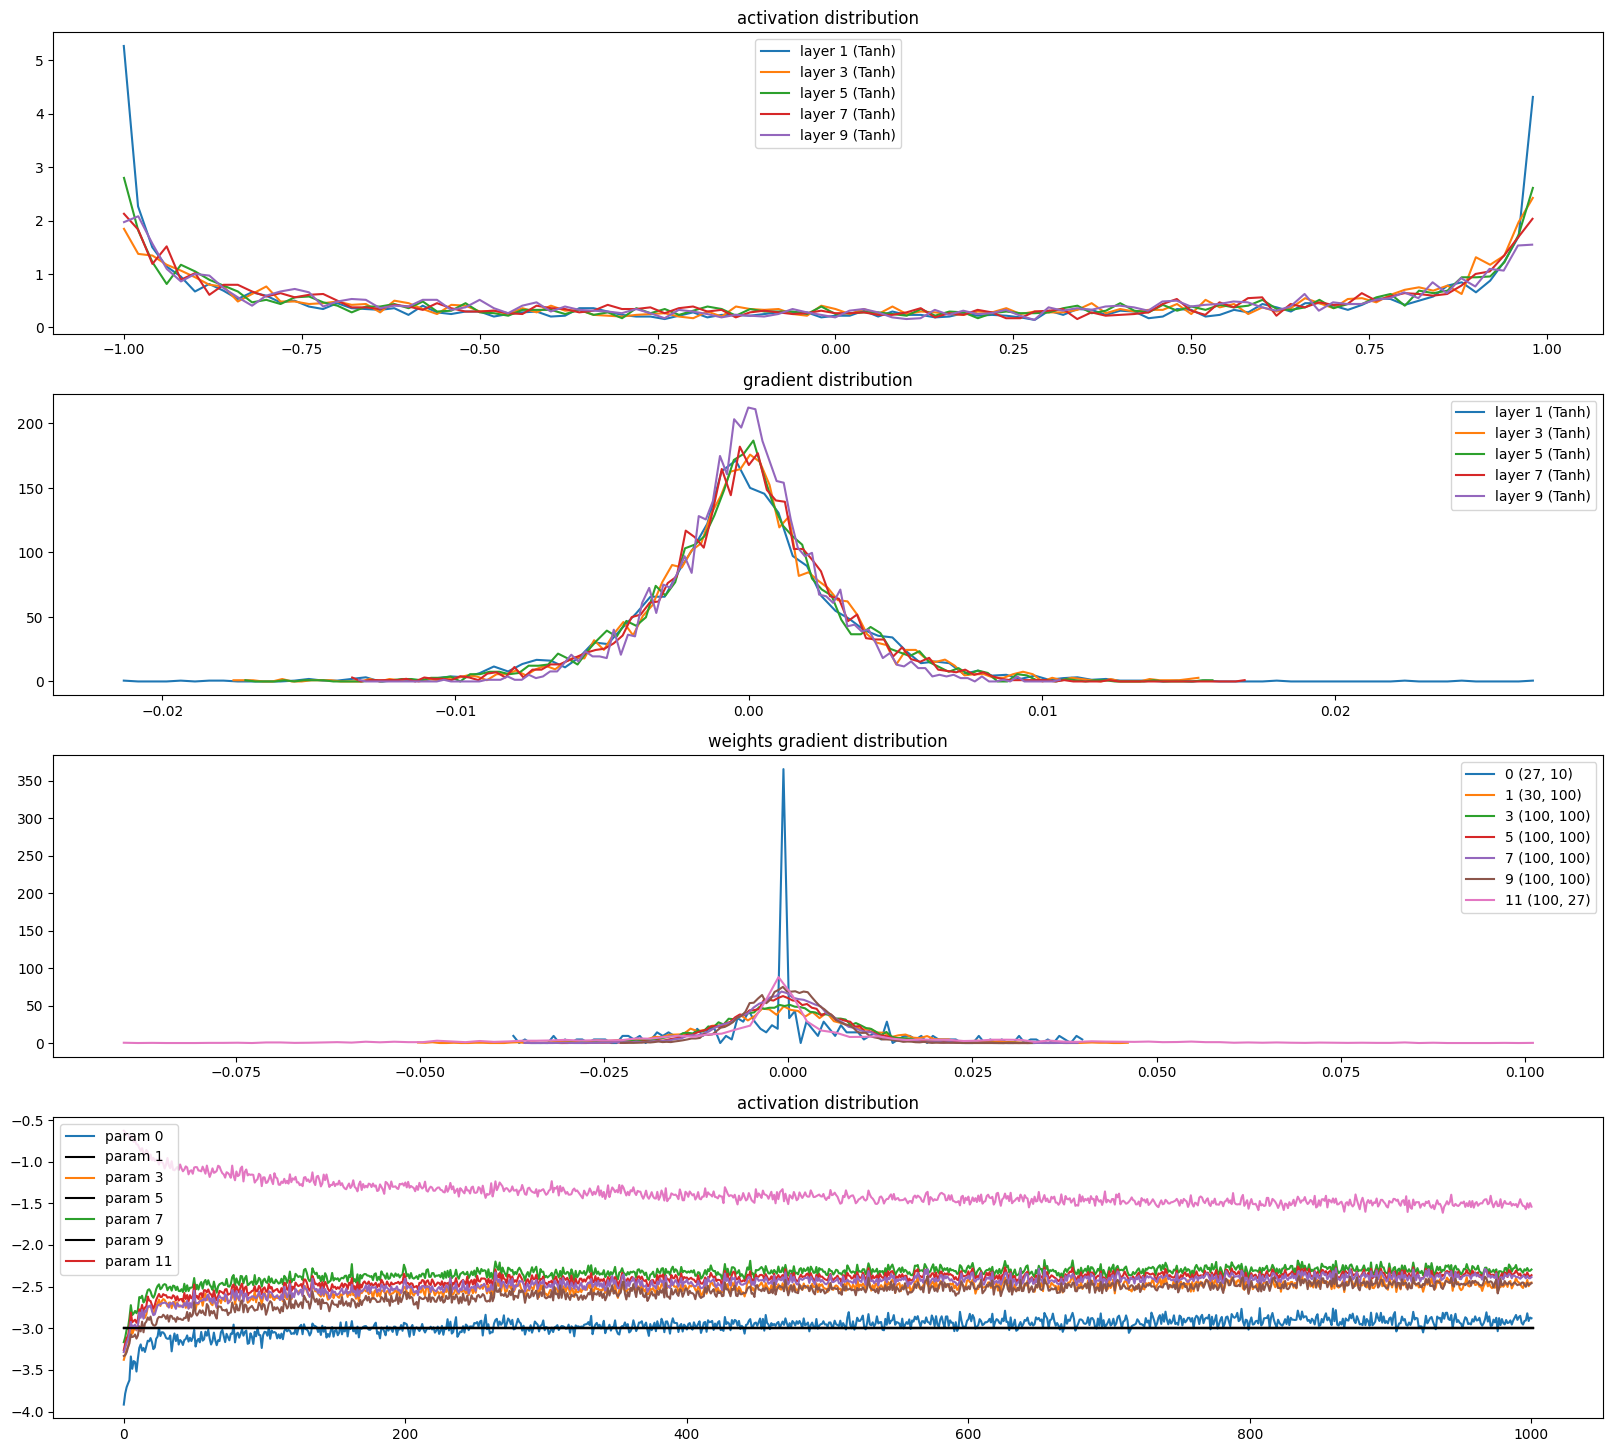

In [305]:
plot_outs(layers, ud)

## With Batch Normalization and gain 0.2 (too low)

In [315]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident at the beginning
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [316]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.3041


Activation Distribution
layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 2.84%
layer 5 (      Tanh): mean +0.01, std 0.65, saturated: 2.31%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.31%
layer 11 (      Tanh): mean -0.00, std 0.66, saturated: 0.66%
layer 14 (      Tanh): mean -0.00, std 0.67, saturated: 0.34%
Gradient Distribution
layer 2 (      Tanh): mean +0.000000, std 1.176647e-03, saturated: 0.000000%
layer 5 (      Tanh): mean -0.000000, std 9.799591e-04, saturated: 0.000000%
layer 8 (      Tanh): mean +0.000000, std 9.271792e-04, saturated: 0.000000%
layer 11 (      Tanh): mean +0.000000, std 9.436258e-04, saturated: 0.000000%
layer 14 (      Tanh): mean -0.000000, std 1.051202e-03, saturated: 0.000000%
Weights Gradient Distribution
weight   (27, 10) | mean -0.000000 | std 7.334609e-03 | grad:data ratio 7.327429e-03
weight  (30, 100) | mean -0.000169 | std 1.170047e-02 | grad:data ratio 1.901635e-01
weight (100, 100) | mean +0.000037 | std 5.629452e-03 | grad

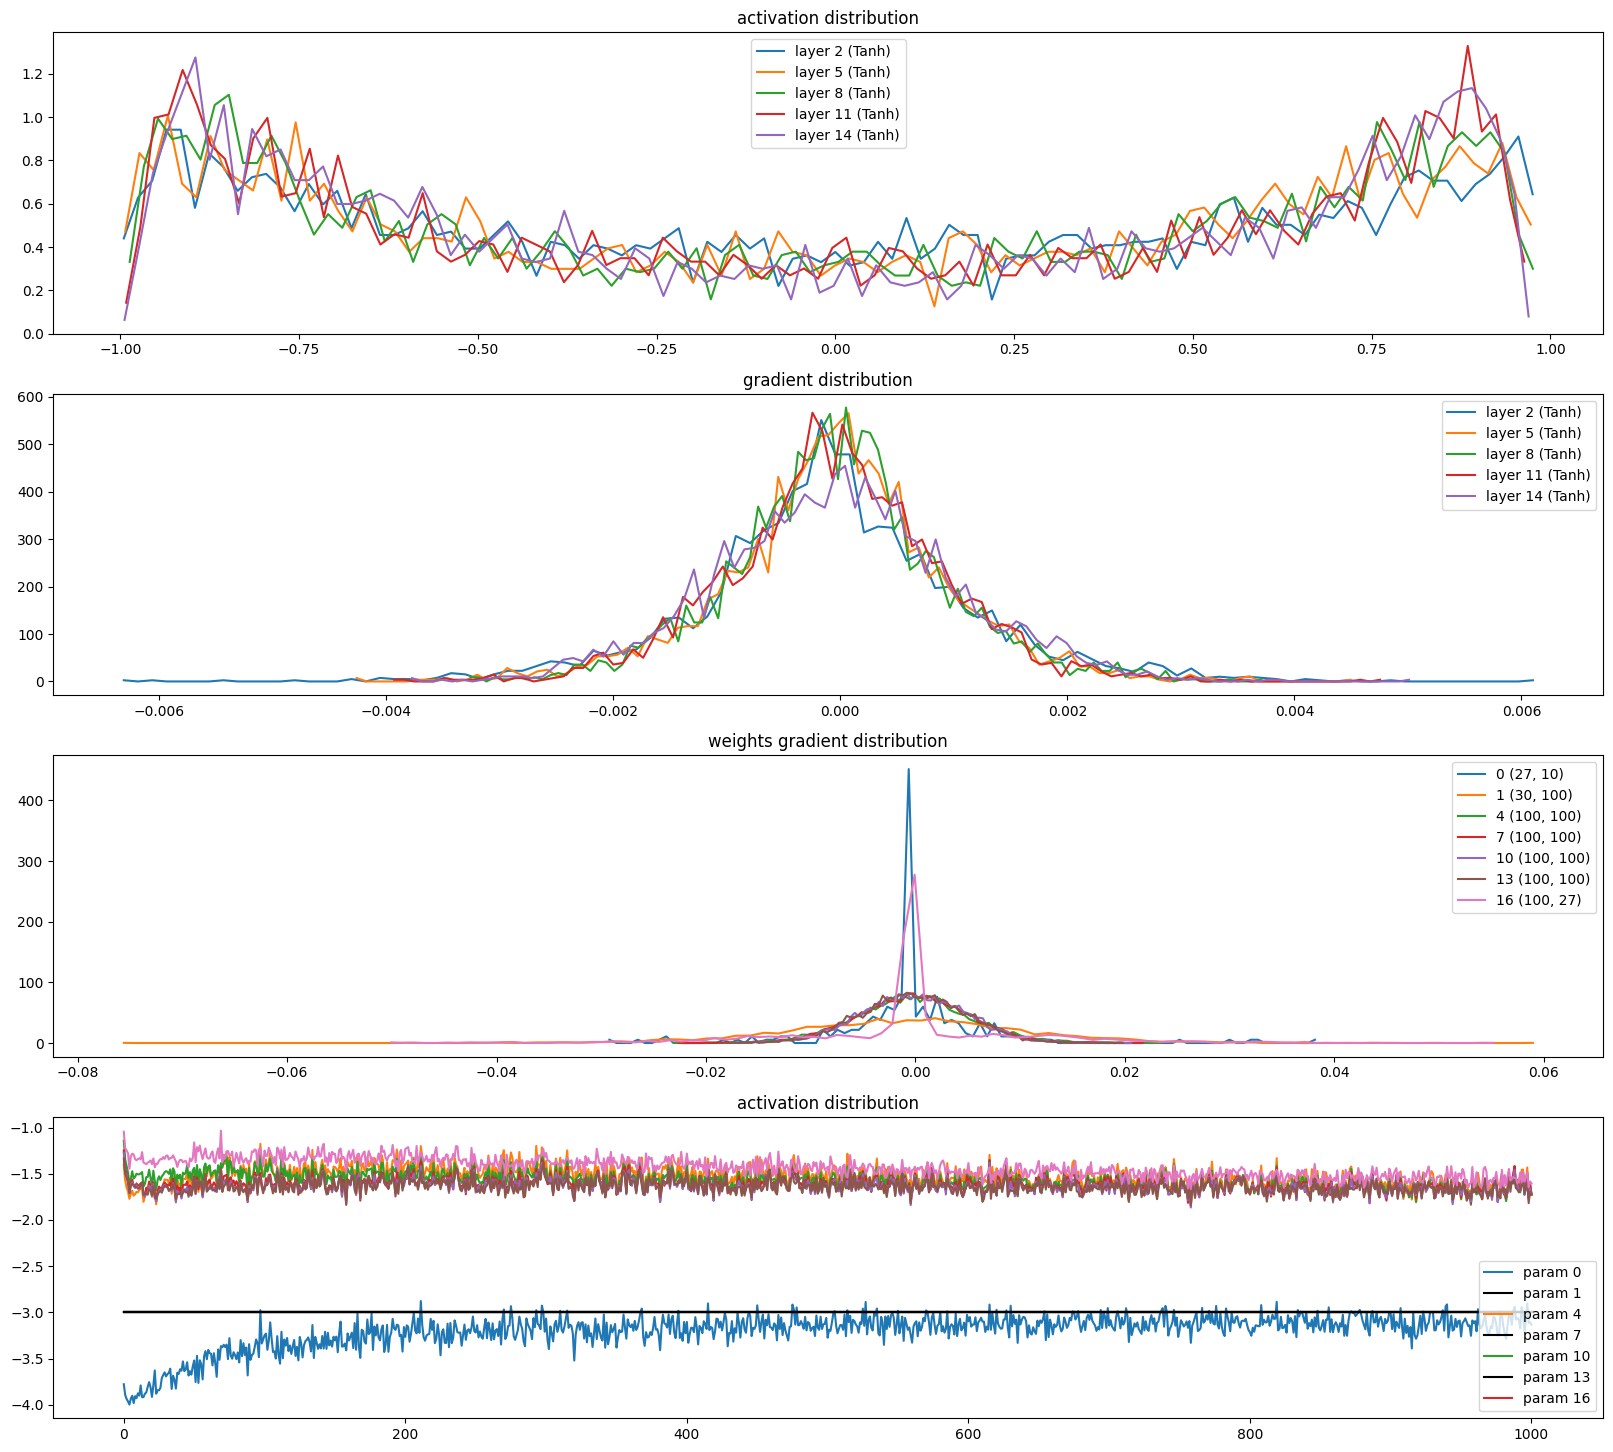

In [317]:
plot_outs(layers, ud)

## With Batch Normalization and gain 5/3

In [ ]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident at the beginning
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    batch_ids = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[batch_ids], y_train[batch_ids]

    # forward pass
    emb = C[X_batch]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.3041


Activation Distribution
layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.66%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.59%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.22%
Gradient Distribution
layer 2 (      Tanh): mean -0.000000, std 3.894868e-03, saturated: 0.000000%
layer 5 (      Tanh): mean +0.000000, std 3.407881e-03, saturated: 0.000000%
layer 8 (      Tanh): mean -0.000000, std 3.119896e-03, saturated: 0.000000%
layer 11 (      Tanh): mean +0.000000, std 2.829433e-03, saturated: 0.000000%
layer 14 (      Tanh): mean +0.000000, std 2.731860e-03, saturated: 0.000000%
Weights Gradient Distribution
weight   (27, 10) | mean -0.000000 | std 1.066631e-02 | grad:data ratio 1.065468e-02
weight  (30, 100) | mean -0.000215 | std 8.568058e-03 | grad:data ratio 2.740384e-02
weight (100, 100) | mean -0.000094 | std 7.319016e-03 | grad

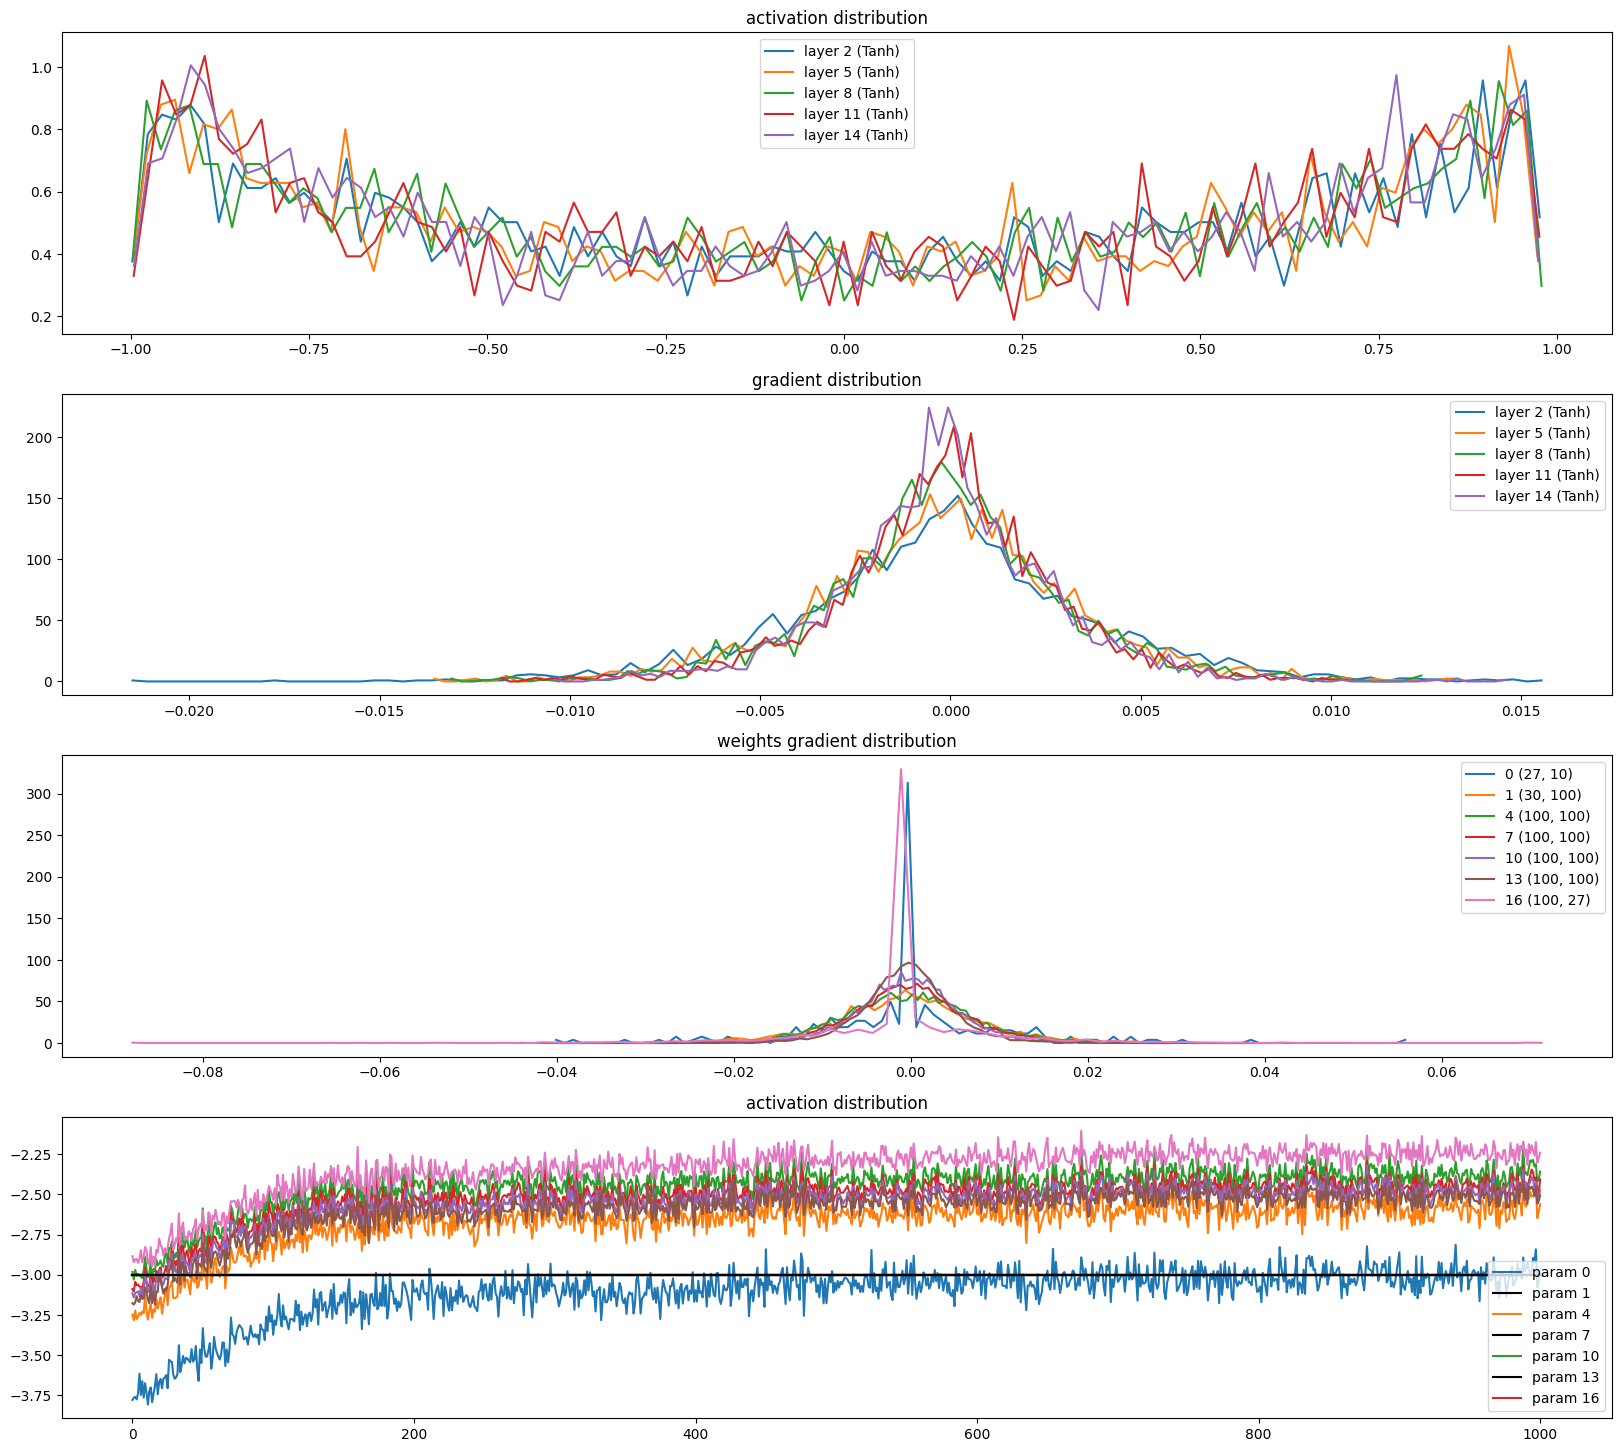

In [ ]:
plot_outs(layers, ud)